## Model

#### (1) SVM, 
#### (2) Naive Bayer, 
#### (3) XGBooster,
#### (4) Logistic, 
#### (5) Dicision Tree, 
#### (6) K-Nearest Neibor, 
#### (7) Random Forest

In [43]:
import pandas as pd
import numpy as np
# from surprise import Dataset, Reader, SVD
# from surprise.model_selection import train_test_split, cross_validate
# from surprise.accuracy import rmse
import matplotlib.pyplot as plt

In [44]:
review_sentiment_df = pd.read_csv('output/LSTM_predictions.csv')
review_sentiment_df

,Unnamed: 0,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id
0,8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,2,P03013220,Bangkok,love,738692369.0
1,14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",1,1,P03013220,Bangkok,surprise,962482865.0
2,17,317504.0,Temple Of Dawn (Wat Arun),Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",0,0,P03013220,Bangkok,joy,955989676.0
3,19,317504.0,Temple Of Dawn (Wat Arun),Family,4.0,0.0,I have to admit that this is a place i have al...,0,0,P03013220,Bangkok,sadness,955712588.0
4,23,456322.0,Wat Umong,Family,5.0,0.0,The visit to this temple was a good pick for u...,1,2,P03013220,Bangkok,joy,936553670.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,5858,1390151.0,Herbal Steam House,Couples,3.0,0.0,Hubby and I stopped in for our third massage s...,0,0,P03015198,Samut Prakan,joy,694006082.0
1164,5866,6668995.0,Wat Intharam,Friends getaway,2.0,0.0,Wat Intharam was apparently built during the A...,1,1,P03015157,Samut Prakan,fear,577527835.0
1165,5880,456191.0,Khuean Srinagarindra National Park,Couples,4.0,1.0,After visiting the nearby waterfalls we drove ...,1,1,P03013837,Samut Prakan,joy,849208855.0
1166,5893,4322899.0,Prasat Wat Sa Kamphaeng Yai,Friends getaway,4.0,1.0,On same site as Prasat Wat Sa Kampheang Noi {w...,0,0,P03013503,Nonthaburi,joy,261414077.0


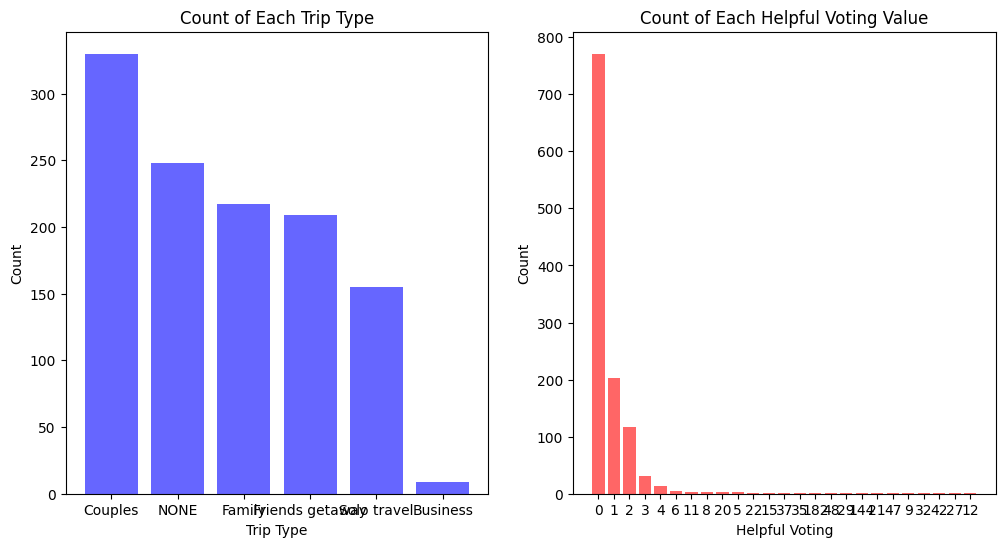

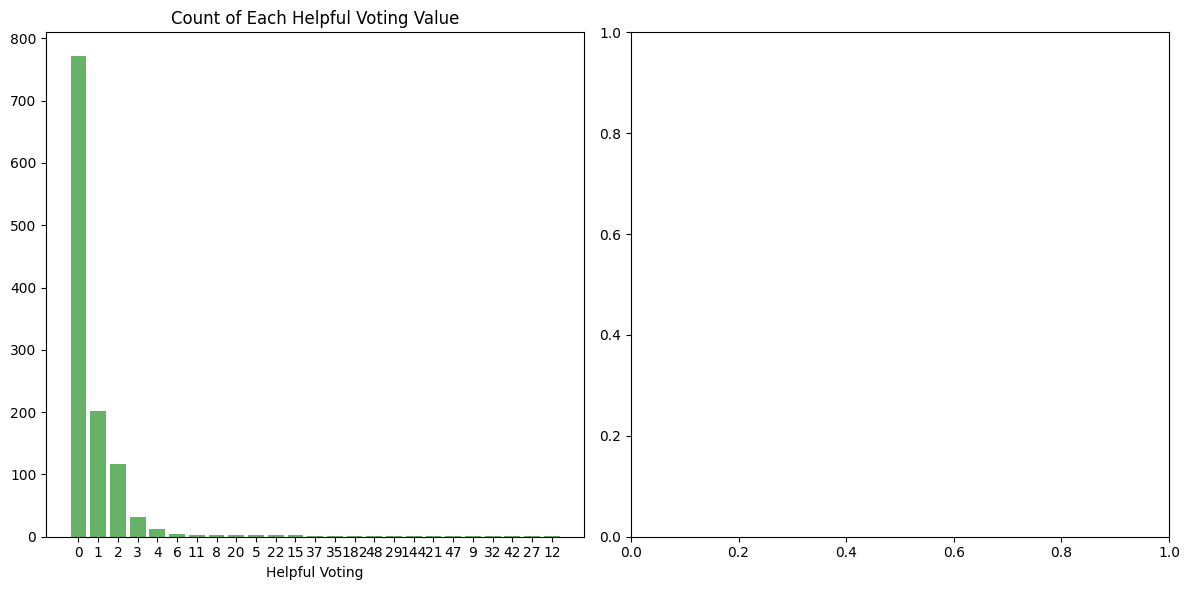

In [45]:
import matplotlib.pyplot as plt


trip_type_counts = review_sentiment_df['trip_type'].value_counts()

helpful_voting_counts = review_sentiment_df['helpful_voting'].astype(int).value_counts()

helpful_voting_counts = review_sentiment_df['helpful_voting'].astype(int).value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(trip_type_counts.index.astype(str), trip_type_counts.values, color='b', alpha=0.6)
ax1.set_xlabel('Trip Type')
ax1.set_ylabel('Count')
ax1.set_title('Count of Each Trip Type')

ax2.bar(helpful_voting_counts.index.astype(str), helpful_voting_counts.values, color='r', alpha=0.6)
ax2.set_xlabel('Helpful Voting')
ax2.set_ylabel('Count')
ax2.set_title('Count of Each Helpful Voting Value')

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))
ax3.bar(helpful_voting_counts.index.astype(str), helpful_voting_counts.values, color='g', alpha=0.6)
ax3.set_xlabel('Helpful Voting')
ax2.set_ylabel('Count')
ax3.set_title('Count of Each Helpful Voting Value')

plt.tight_layout()

plt.show()


In [46]:
print(review_sentiment_df['trip_type'].values)

['NONE' 'Couples' 'Solo travel' ... 'Couples' 'Friends getaway'
 'Friends getaway']


In [48]:
review_sentiment_df[["predicted_sentiment", "helpful_voting", "rating", "location_name", "place_name", "review_id"]]

,predicted_sentiment,helpful_voting,rating,location_name,place_name,review_id
0,2,2.0,5.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,Bangkok,738692369.0
1,1,0.0,5.0,Wat Phra Chetuphon,Bangkok,962482865.0
2,0,15.0,5.0,Temple Of Dawn (Wat Arun),Bangkok,955989676.0
3,0,0.0,4.0,Temple Of Dawn (Wat Arun),Bangkok,955712588.0
4,2,0.0,5.0,Wat Umong,Bangkok,936553670.0
...,...,...,...,...,...,...
1163,0,0.0,3.0,Herbal Steam House,Samut Prakan,694006082.0
1164,1,0.0,2.0,Wat Intharam,Samut Prakan,577527835.0
1165,1,1.0,4.0,Khuean Srinagarindra National Park,Samut Prakan,849208855.0
1166,0,1.0,4.0,Prasat Wat Sa Kamphaeng Yai,Nonthaburi,261414077.0


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [50]:
# Step 1: Create a proxy score based on a heuristic formula
review_sentiment_df['proxy_score'] = (0.5 * review_sentiment_df['rating']) + \
                                     (0.2 * review_sentiment_df['helpful_voting']) + \
                                     (0.3 * review_sentiment_df['predicted_sentiment'])


# Features and proxy score as target
X = review_sentiment_df[['rating', 'predicted_sentiment', 'helpful_voting']]
y = review_sentiment_df['proxy_score']

# Step 2: Split data into training (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Initialize XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Step 4: Train the model using proxy scores
model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on test set: {mse}')

# Step 7: Predict scores for the entire dataset
review_sentiment_df['predicted_score'] = model.predict(X)
print(review_sentiment_df[['location_name', 'place_name', 'predicted_score']])

Mean Squared Error on test set: 0.016830854473337972
                                        location_name    place_name  \
0     Wat Rajapradit Sathitmahasimaram Rajaworavihara       Bangkok   
1                                  Wat Phra Chetuphon       Bangkok   
2                           Temple Of Dawn (Wat Arun)       Bangkok   
3                           Temple Of Dawn (Wat Arun)       Bangkok   
4                                           Wat Umong       Bangkok   
...                                               ...           ...   
1163                               Herbal Steam House  Samut Prakan   
1164                                     Wat Intharam  Samut Prakan   
1165               Khuean Srinagarindra National Park  Samut Prakan   
1166                      Prasat Wat Sa Kamphaeng Yai    Nonthaburi   
1167                                  Prasat Puay Noi    Nonthaburi   

      predicted_score  
0            3.499147  
1            2.800333  
2            5.137371 

In [9]:
import plotly.express as px

In [24]:
# Create scatter plot using Plotly
fig = px.scatter(
    review_sentiment_df, 
    x='place_name', 
    y='predicted_score', 
    color='place_name',  # Optional: to color points by place_name
    hover_data=['location_name'],  # Display location_name when hovering
    title="Scatter Plot of Predicted Scores by Place Name"
)

# Show the plot
fig.show()

In [51]:

# Plot predicted scores against rating
fig1 = px.scatter(
    review_sentiment_df, 
    x='rating', 
    y='predicted_score', 
    title="Predicted Score vs Rating", 
    labels={'rating': 'Rating', 'predicted_score': 'Predicted Score'}
)
fig1.show()

# Plot predicted scores against predicted_sentiment
fig2 = px.scatter(
    review_sentiment_df, 
    x='predicted_sentiment', 
    y='predicted_score', 
    title="Predicted Score vs Predicted Sentiment", 
    labels={'predicted_sentiment': 'Predicted Sentiment', 'predicted_score': 'Predicted Score'}
)
fig2.show()

# Plot predicted scores against helpful_voting
fig3 = px.scatter(
    review_sentiment_df, 
    x='helpful_voting', 
    y='predicted_score', 
    title="Predicted Score vs Helpful Voting", 
    labels={'helpful_voting': 'Helpful Voting', 'predicted_score': 'Predicted Score'}
)
fig3.show()

In [53]:
len(list(set(review_sentiment_df['place_name'].values)))

17

In [52]:
def get_best_location_in_place(place_name):
    place_df = review_sentiment_df[review_sentiment_df['place_name'] == place_name]
    best_location = place_df.loc[place_df['predicted_score'].idxmax()]
    return best_location['location_name'], best_location['predicted_score']

def suggest_locations_in_other_places(exclude_place_name, top_n=3):
    other_places_df = review_sentiment_df[review_sentiment_df['place_name'] != exclude_place_name]
    top_suggestions = other_places_df.sort_values(by='predicted_score', ascending=False).head(top_n)
    return top_suggestions[['location_name', 'place_name', 'predicted_score']]

In [54]:
place_name = 'Nonthaburi'

best_location, best_score = get_best_location_in_place(place_name)
print(f">>>> Best location in {place_name}: {best_location} with a score of {best_score}")

suggestions = suggest_locations_in_other_places(place_name, top_n=5)
print(f"\n>>>> Suggestions in other places:\n")
suggestions

>>>> Best location in Nonthaburi: Wat Amphawan Chetiyaram with a score of 39.499847412109375

>>>> Suggestions in other places:



,location_name,place_name,predicted_score
600,Rim Moei Market,Nakhon Sawan,30.600584
317,King Naresuan Monument,Phra Nakhon Si Ayutthaya,11.698114
779,Wachira Benchathat Park (Rot Fai Park),Phichit,11.400679
920,Khao Phra Tamnak (Khao Phra Bat),Bangkok,9.840777
26,Erawan Shrine (Thao Mahaprom Shrine),Bangkok,9.702078


In [42]:
print(review_sentiment_df[['location_name', 'proxy_score']])

                                        location_name  proxy_score
0     Wat Rajapradit Sathitmahasimaram Rajaworavihara          3.2
1                                  Wat Phra Chetuphon          2.4
2                           Temple Of Dawn (Wat Arun)          5.0
3                           Temple Of Dawn (Wat Arun)          1.6
4                                           Wat Umong          2.4
...                                               ...          ...
1163                               Herbal Steam House          1.2
1164                                     Wat Intharam          1.2
1165               Khuean Srinagarindra National Park          2.2
1166                      Prasat Wat Sa Kamphaeng Yai          1.8
1167                                  Prasat Puay Noi          2.4

[1168 rows x 2 columns]


In [63]:
review_sentiment_df[['review_id', 'location_name', 'rating']]

,review_id,location_name,rating
0,738692369.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,5.0
1,962482865.0,Wat Phra Chetuphon,5.0
2,955989676.0,Temple Of Dawn (Wat Arun),5.0
3,955712588.0,Temple Of Dawn (Wat Arun),4.0
4,936553670.0,Wat Umong,5.0
...,...,...,...
1163,694006082.0,Herbal Steam House,3.0
1164,577527835.0,Wat Intharam,2.0
1165,849208855.0,Khuean Srinagarindra National Park,4.0
1166,261414077.0,Prasat Wat Sa Kamphaeng Yai,4.0


In [66]:
from surprise import Dataset, Reader, SVD
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(review_sentiment_df[['review_id', 'location_name', 'rating']], reader)


In [68]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2)

In [78]:
review_sentiment_df.iloc[500:505]

,Unnamed: 0,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id,proxy_score,predicted_score
500,2476,6878365.0,Namtok Ngao National Park,Family,3.0,0.0,Not far off the main highway these high falls ...,1,0,P03005928,Saraburi,joy,427149765.0,1.5,1.499789
501,2478,6878365.0,Namtok Ngao National Park,Friends getaway,5.0,0.0,this is one of the best place.\nno commercial ...,2,2,P03005928,Saraburi,joy,239464944.0,3.1,3.099694
502,2484,6669416.0,Namtok Yong National Park,Family,3.0,1.0,Easy to reach by car from Thungsong - and only...,2,2,P03005928,Saraburi,joy,490284622.0,2.3,2.301416
503,2495,3384454.0,Khao Yoi Cave,Family,5.0,2.0,Tham khao Yoi temple next to the cave is a mus...,2,2,P03004509,Saraburi,joy,701459085.0,3.5,3.499147
504,2498,3445712.0,Khao Mai Kaew Cave,Couples,5.0,0.0,The Khao Mai Kaew cave was an interesting and ...,1,1,P03004509,Saraburi,joy,890723374.0,2.8,2.800333


In [79]:
model = SVD()
model.fit(trainset)

# Step 5: Get predictions for the test set
predictions = model.test(testset)
print(f"Collaborative Filtering RMSE: {accuracy.rmse(predictions)}")

# Step 6: Collaborative Filtering predictions for a specific review-item pair
review_id = 765890432
item_id = 'Khao Yoi Cave'
collab_pred = model.predict(review_id, item_id).est
print(f"Collaborative Filtering prediction for Review {review_id} on {item_id}: {collab_pred}")

RMSE: 0.9879
Collaborative Filtering RMSE: 0.9879275928641755
Collaborative Filtering prediction for Review 765890432 on Khao Yoi Cave: 4.251600424293963


In [80]:
# Define weights for each method
collab_weight = 0.6
content_weight = 0.4

# Get the content-based score for a specific item (e.g., 'Wat Pho')
content_pred = review_sentiment_df[review_sentiment_df['location_name'] == item_id]['proxy_score'].values[0]

# Combine both scores into a final hybrid score
hybrid_score = (collab_weight * collab_pred) + (content_weight * content_pred)

print(f"Hybrid Recommendation Score for {review_id} on {item_id}: {hybrid_score} of 5")


Hybrid Recommendation Score for 765890432 on Khao Yoi Cave: 3.950960254576378 of 5


## หลักการ
ระบบแนะนำแบบไฮบริดเป็นการผสมผสานระหว่าง **Collaborative Filtering (CF)** และ **Content-Based Filtering (CBF)** เพื่อใช้ประโยชน์จากทั้งสองวิธี:

- **Collaborative Filtering (CF)**: วิเคราะห์พฤติกรรมการให้คะแนนของผู้ใช้ที่คล้ายกัน เพื่อแนะนำสถานที่ที่ผู้ใช้อาจจะชอบ
- **Content-Based Filtering (CBF)**: วิเคราะห์คุณลักษณะของสถานที่ เช่น ความรู้สึกในการรีวิว (sentiment) หรือจำนวนการโหวต (helpful voting) เพื่อแนะนำสถานที่ที่มีลักษณะคล้ายกับที่ผู้ใช้เคยชอบ

## การคำนวณ
คะแนนไฮบริดคำนวณจากการถ่วงน้ำหนักระหว่าง CF และ CBF โดยใช้สูตร:

$$ 
\text{Hybrid Score} = (\text{Weight}_{CF} \times \text{CF Score}) + (\text{Weight}_{CBF} \times \text{CBF Score}) 
$$

ซึ่ง **Weight** จะถูกกำหนดตามความสำคัญของแต่ละโมเดลในระบบ

## การตีความ
- **คะแนนใกล้ 5**: โมเดลคาดว่าผู้ใช้หรือรีวิวนี้น่าจะชอบสถานที่มาก
- **คะแนนใกล้ 1**: โมเดลคาดว่าผู้ใช้ไม่น่าจะชอบสถานที่นั้น
- **คะแนนกลางๆ**: ผู้ใช้อาจรู้สึกกลางๆ กับสถานที่นั้น

คะแนนนี้สามารถนำไปใช้เพื่อจัดลำดับความสำคัญในการแนะนำสถานที่ต่างๆ ให้กับผู้ใช้ตามความชอบที่คาดการณ์


In [98]:
def recommend_top5_locations(review_id, svd_model, review_sentiment_df, content_weights=(0.4, 0.3, 0.3), cf_weight=0.6, cbf_weight=0.4):
    """
    Recommend the top 5 locations that the user (review_id) might like based on hybrid recommendation.

    Parameters:
    review_id (int): The review ID for which to recommend locations.
    svd_model (SVD): The trained SVD collaborative filtering model.
    review_sentiment_df (pd.DataFrame): The DataFrame containing review data and content features.
    content_weights (tuple): Weights for content-based features (rating, helpful_voting, predicted_sentiment).
    cf_weight (float): Weight for collaborative filtering score.
    cbf_weight (float): Weight for content-based filtering score.

    Returns:
    pd.DataFrame: Top 5 recommended locations with their hybrid scores.
    """
    # Get the list of all locations
    all_locations = review_sentiment_df['location_name'].unique()
    
    # Get the locations that the user (review_id) has already reviewed
    reviewed_locations = review_sentiment_df[review_sentiment_df['review_id'] == review_id]['location_name'].unique()
    
    # Filter out locations that the user has already reviewed
    locations_to_recommend = [loc for loc in all_locations if loc not in reviewed_locations]
    
    recommendations = []

    # Normalize content features to avoid domination by one feature
    min_rating = review_sentiment_df['rating'].min()
    max_rating = review_sentiment_df['rating'].max()
    min_helpful = review_sentiment_df['helpful_voting'].min()
    max_helpful = review_sentiment_df['helpful_voting'].max()
    min_sentiment = review_sentiment_df['predicted_sentiment'].min()
    max_sentiment = review_sentiment_df['predicted_sentiment'].max()

    for location in locations_to_recommend:
        # Step 1: Collaborative Filtering (CF) Score
        try:
            cf_score = svd_model.predict(review_id, location).est
        except:
            cf_score = 0  # In case prediction fails for any reason
        
        # Step 2: Content-Based Filtering (CBF) Score
        location_data = review_sentiment_df[review_sentiment_df['location_name'] == location].iloc[0]
        
        # Normalize the content-based features to a 0-1 scale
        normalized_rating = (location_data['rating'] - min_rating) / (max_rating - min_rating)
        normalized_helpful = (location_data['helpful_voting'] - min_helpful) / (max_helpful - min_helpful)
        normalized_sentiment = (location_data['predicted_sentiment'] - min_sentiment) / (max_sentiment - min_sentiment)
        
        cbf_score = (
            content_weights[0] * normalized_rating +
            content_weights[1] * normalized_helpful +
            content_weights[2] * normalized_sentiment
        )
        
        # Step 3: Hybrid Score (weighted combination of CF and CBF scores)
        hybrid_score = (cf_weight * cf_score) + (cbf_weight * cbf_score)
        
        # Append the location and the hybrid score to the list
        recommendations.append((location, hybrid_score))
    
    # Sort the recommendations by hybrid score in descending order
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    
    # Convert to DataFrame for easier reading and select top 5
    recommendations_df = pd.DataFrame(recommendations, columns=['location_name', 'hybrid_score'])
    
    return recommendations_df.head(5)


In [99]:
review_sentiment_df[['review_id']].astype(int).iloc[:100].head(10)

,review_id
0,738692369
1,962482865
2,955989676
3,955712588
4,936553670
5,962490689
6,935907604
7,890055418
8,947799000
9,946867745


In [106]:
picked_review_id = 738692369
review_sentiment_df[review_sentiment_df['review_id'] == picked_review_id]

,Unnamed: 0,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id,proxy_score,predicted_score
0,8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,2,P03013220,Bangkok,love,738692369.0,3.5,3.499147


In [107]:
# Example usage
top5_recommendations = recommend_top5_locations(review_id=picked_review_id, svd_model=model, review_sentiment_df=review_sentiment_df)
print(top5_recommendations)

                      location_name  hybrid_score
0           Wat Amphawan Chetiyaram      2.947568
1             Wat Khao Suwan Pradit      2.872810
2  Phra Thinang Aisawan Thiphta-Art      2.866534
3            Sea Dragon Dive Center      2.866124
4                Soi Dog Foundation      2.865616


In [2]:
import mlflow
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
FILE_PATH = "../dataset/full_embled_review_combined.csv"

In [4]:
def load_and_prepare_data(file_path):
    """
    Load and prepare data for modeling.
    """
    df = pd.read_csv(file_path)
    
    # Data cleaning and feature engineering (as in the previous steps)
    df.dropna(inplace=True)
    df['sentiment'] = df['sentiment'].map({'positive': 1, 'neutral': 0.5, 'negative': 0})
    df['weighted_rating'] = df['rating'] * df['sentiment'] * df['helpful_vote']
    
    # Features and labels
    X = df[['rating', 'sentiment', 'helpful_vote', 'weighted_rating']]
    y = df['rating']  # Assuming the target is 'rating' in this case
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def objective(trial):
    """
    Optuna objective function for hyperparameter tuning.
    """
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 2, 10)

    # Train-test split
    X_train, X_test, y_train, y_test = load_and_prepare_data(FILE_PATH)

    # Create and train model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)

    # Predict and evaluate
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    # Log parameters and metrics with MLFlow
    with mlflow.start_run():
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "random_forest_model")
    
    return accuracy

In [6]:
def run_optuna_optimization():
    """
    Run Optuna to optimize hyperparameters.
    """
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    print(f"Best parameters: {study.best_params}")
    print(f"Best accuracy: {study.best_value}")

In [8]:
mlflow.set_experiment("Delta-Project")
run_optuna_optimization()

[I 2024-09-28 12:51:11,042] A new study created in memory with name: no-name-49efd6eb-87e7-4eed-88de-c5fd074074f8
/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_5574/630592448.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
[W 2024-09-28 12:51:15,978] Trial 0 failed with parameters: {'n_estimators': 167, 'max_depth': 5} because of the following error: KeyError('helpful_vote').
Traceback (most recent call last):
  File "/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 153, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 182, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_h

KeyError: 'helpful_vote'